# Amazon Fine Food Reviews KNN Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
import plotly

C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

In [5]:
# Sampling the data :
sample_data = data.sample(n=10000)
sample_data['Score'].value_counts()

positive    8419
negative    1581
Name: Score, dtype: int64

In [6]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
34053,7520,8212,B000BXUVYG,A2THPS6XS0W6QP,"Angeline Schmit ""Ang2007""",7,9,negative,1187049600,Causes Vomiting!!!!,Both of my cats vomit from all Temptations tre...,b'cat vomit temptat treat especi hairbal varie...
338093,421199,455522,B005HG9ERW,A2S26YGSVXBCFL,"Morley Dotes ""morleydotes""",0,0,positive,1344038400,Tastes Pretty Good!,Essentia tastes great. I am usually a Fiji fan...,b'essentia tast great usual fiji fan essentia ...


## Time Based Splitting :

In [7]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
3402,184396,200021,B0000D9N5Q,A176XYKMRF1U8Q,Lance Arthur,0,0,positive,1067990400,A small taste of heaven,Pierre Robert is similar to Brie but with a sm...,b'pierr robert similar brie smoother creamier ...
3774,269060,291708,B0000DG55P,A4UKBG3M5U5TI,Westley,2,2,positive,1071792000,Unusual Hot Sauce,"When Americans want to add some heat to food, ...",b'american want add heat food usual think mexi...


In [8]:
# Getting the Labels i.e the Score out of the dataframe.
y = sorted_sample['Score']
# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
3402,184396,200021,B0000D9N5Q,A176XYKMRF1U8Q,Lance Arthur,0,0,1067990400,A small taste of heaven,Pierre Robert is similar to Brie but with a sm...,b'pierr robert similar brie smoother creamier ...
3774,269060,291708,B0000DG55P,A4UKBG3M5U5TI,Westley,2,2,1071792000,Unusual Hot Sauce,"When Americans want to add some heat to food, ...",b'american want add heat food usual think mexi...


In [9]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:6000]
y_train = y[0:6000]
x_test = sorted_sample[6000:10000]
y_test = y[6000:10000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (6000, 11)
Test Set -  (4000, 11)


## Bag of Words (BoW) :

In [10]:
# Generating bag of words features.
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(x_train['CleanedText'].values)
bow_train = bow_train.todense()
bow_train.shape

(6000, 10572)

In [11]:
bow_test = count_vect.transform(x_test['CleanedText'].values)
bow_test = bow_test.todense()
bow_test.shape

(4000, 10572)

#### Finding optimal lambda using grdisearch and randomsearch :

In [12]:
# Importing Logistics Regression and Grid and Random Search.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [13]:
# Logistic Regression models with L1 and L2 Regularizations.
lr1 = LogisticRegression(penalty='l1')
lr2 = LogisticRegression(penalty='l2')

In [14]:
# C = 1/lambda , Generating C Values :
C = [{ 'C':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
C

[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]

In [15]:
# Using grid search to find optimal C or 1/lamda
model1 = GridSearchCV(lr1, C)
model1.fit(bow_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
# Getting the best model
model1.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# Evaluating the model
model1.score(bow_test, y_test)

0.88949999999999996

In [18]:
# Performing gridsearch this time with l1 regularisation.
model2 = GridSearchCV(lr2, C)
model2.fit(bow_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
model2.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
model2.score(bow_test, y_test)

0.89600000000000002

**Grid Search Conclusions for Bag of Words **
* GridSearch gave the value of C as 1 for both l1 and l2 regularized models.
* Accuracy for both the models is almost same.

** Using RandomizedSearchCV now **

In [21]:
# Import randint library to generate distributions.
from scipy.stats import randint as sp_randint

In [22]:
# Generating random values.
C_rscv = {'C':sp_randint(10**-2, 10**2)}
C_rscv

{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x286d0e06860>}

In [23]:
# Using RandomizedSearchCv
model3 = RandomizedSearchCV(lr1, C_rscv)
model3.fit(bow_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [24]:
# Getting the best estimator
model3.best_estimator_

LogisticRegression(C=57, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# Score obtained.
model3.score(bow_test, y_test)

0.873

In [26]:
# Doing the same thing for model lr2.
model4 = RandomizedSearchCV(lr2, C_rscv)
model4.fit(bow_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [27]:
model4.best_estimator_

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
model4.score(bow_test, y_test)

0.88924999999999998

** RandomizedSearchCV results for Bag of Words **
* Randomized search gave the value of C = 57 for l1 regularized model and C = 5 for l2 regularized model.

** Now checking sparsity with different values of lamda or C **

In [29]:
C_sparse = np.arange(0, 100, 0.5)
C_sparse = C_sparse[1:]
C_sparse.shape

(199,)

In [30]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(bow_train, y_train)
    error.append(1- m.score(bow_test, y_test))
    spc.append(np.count_nonzero(m.coef_))

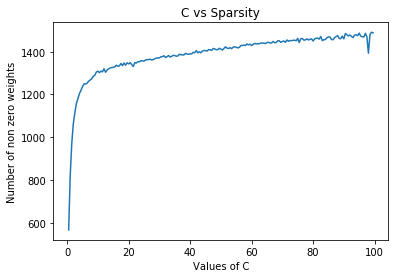

In [31]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

> at lowers values of C i.e higher lambda we get most of the weights to be 0. At higher values of C this number decreases and non-zero weights increases.

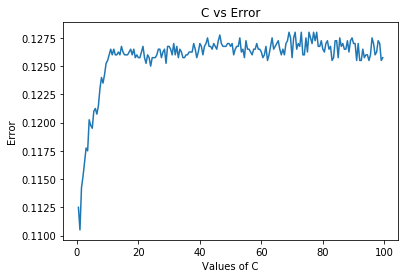

In [32]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()

#### Feature importance :
1. Testing multicollinearity.
2. Getting important features.

** Pertubation test **

In [33]:
# Adding small noise to train data.
epsilon = 0.05
bow_train_2 = bow_train + epsilon
bow_train_2.shape

(6000, 10572)

In [34]:
# training Logistic Regression on this new modified dataset.
m1 = LogisticRegression()
m1.fit(bow_train_2, y_train)
m1.coef_

array([[ 0.00540902, -0.14379936,  0.01806588, ...,  0.00426706,
         0.07322853,  0.17925378]])

In [35]:
# Trainiong Logistic Regression on old dataset.
m2 = LogisticRegression()
m2.fit(bow_train, y_train)
m2.coef_

array([[  1.18095680e-03,  -1.47918971e-01,   1.41277425e-02, ...,
          5.46769347e-05,   6.75687678e-02,   1.77296831e-01]])

In [36]:
m2.coef_ - m1.coef_

array([[-0.00422806, -0.00411961, -0.00393814, ..., -0.00421239,
        -0.00565976, -0.00195695]])

> As we can see that the difference between two models w and w~ is small we can say that the features are not multicollinear.
> As a result we can use w to get the feature importance.

** Getting most important features ** 

In [37]:
# Creating a dataframe with feature - weights.
df = pd.DataFrame(data=m2.coef_.reshape(-1,1), index=count_vect.get_feature_names())

In [38]:
# Dataframe created.
# Now taking absolute value of every w in Df.
df[0] = df[0].abs()
df.head()

,0
aaa,0.001181
aaaaaaarrrrrggghhh,0.147919
aaf,0.014128
aafter,0.003096
aback,0.004246


In [39]:
# Getting 10 most important features.
# Note feature in Bag of words is a word.
df.sort_values(by = 0, ascending=False).head(10)

,0
worst,2.353657
terribl,1.949626
best,1.700677
delici,1.663967
aw,1.599521
wast,1.537287
disappoint,1.504872
overpr,1.478816
excel,1.468682
amaz,1.435711


## TFIDF :

In [40]:
# Generating TFIDF features.
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train['CleanedText'].values)
tf_train = tf_train.todense()
tf_train.shape

(6000, 10572)

In [41]:
tf_test = tfidf.transform(x_test['CleanedText'].values)
tf_test = tf_test.todense()
tf_test.shape

(4000, 10572)

** GridSearchCV **

In [42]:
# Logistic regression with L1 regularization.
model1 = GridSearchCV(lr1, C)
model1.fit(tf_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
# Getting the best model
model1.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
# Result on test data.
model1.score(tf_test, y_test)

0.88424999999999998

In [45]:
# Logistics Regression with L2 regularisation.
model2 = GridSearchCV(lr2, C)
model2.fit(tf_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
# Best model characteristics.
model2.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
# Test data result.
model2.score(tf_test, y_test)

0.89400000000000002

** Grdisearch results **
* Using GridSearch for TFIDF we get C = 10 for both the models.
* Accuracy is once again almost similar with a difference of just 0.01

** RandomSeachCV **

In [48]:
# Using RandomizedSearchCv
model3 = RandomizedSearchCV(lr1, C_rscv)
model3.fit(tf_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [49]:
model3.best_estimator_

LogisticRegression(C=29, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
model3.score(tf_test, y_test)

0.87975000000000003

In [51]:
model4 = RandomizedSearchCV(lr2, C_rscv)
model4.fit(tf_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [52]:
model4.best_estimator_

LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
model4.score(tf_test, y_test)

0.89424999999999999

** Randomized Search results **
* L1 regularized model scored best when C = 29, for L2 best was C = 15

** Checking sparsity **

In [54]:
# Generating a range of value to check.
C_sparse = np.arange(0, 100, 0.5)
C_sparse = C_sparse[1:]
C_sparse.shape

(199,)

In [55]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(tf_train, y_train)
    error.append(1- m.score(tf_test, y_test))
    spc.append(np.count_nonzero(m.coef_))

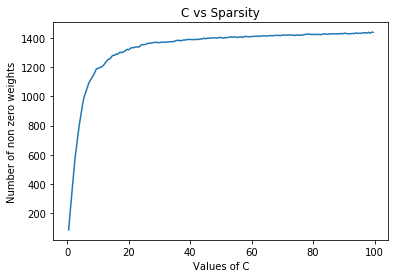

In [56]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

> Here again the same thing is observed as lambda decreases or C increases the number of non-zero values in w increase or sparsity decreases.

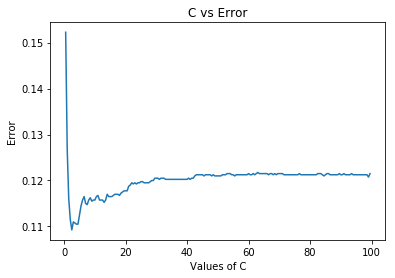

In [57]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()

#### Feature importance :
1. Testing multicollinearity.
2. Getting important features.

** Pertubation test **

In [58]:
# Adding small noise to train data.
epsilon = 0.05
tf_train_2 = tf_train + epsilon
tf_train_2.shape

(6000, 10572)

In [59]:
# training Logistic Regression on this new modified dataset.
m1 = LogisticRegression()
m1.fit(tf_train_2, y_train)
m1.coef_

array([[ 0.02261717, -0.09845798,  0.01923477, ...,  0.02031439,
         0.06693168,  0.06271706]])

In [60]:
# Training logistics regression on old dataset.
m2 = LogisticRegression()
m2.fit(tf_train, y_train)
m2.coef_

array([[ 0.01812809, -0.10300365,  0.01477623, ...,  0.01577669,
         0.06241705,  0.05858599]])

In [61]:
m2.coef_ - m1.coef_

array([[-0.00448908, -0.00454567, -0.00445854, ..., -0.0045377 ,
        -0.00451463, -0.00413107]])

> As we can see that the difference between two models w and w~ is small we can say that the features are not multicollinear.
> As a result we can use w to get the feature importance.

** Getting most important features ** 

In [62]:
# Creating a dataframe with feature - weights.
df = pd.DataFrame(data=m2.coef_.reshape(-1,1), index=tfidf.get_feature_names())

In [63]:
# Dataframe created.
# Now taking absolute value of every w in Df.
df[0] = df[0].abs()
df.head()

,0
aaa,0.018128
aaaaaaarrrrrggghhh,0.103004
aaf,0.014776
aafter,0.020451
aback,0.019264


In [64]:
# Getting 10 most important features.
# Note feature in Bag of words is a word.
df.sort_values(by = 0, ascending=False).head(10)

,0
great,4.715716
love,4.044021
best,3.829525
disappoint,3.328657
good,2.979243
delici,2.926475
bad,2.856704
return,2.822287
worst,2.689972
money,2.626614


## Word2Vec :
* We will train W2V on our train dataset.

In [65]:
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [66]:
# converting the train set into clean form which does not contain html tags etc.
import gensim
i=0
list_of_sent_train=[]
for sent in x_train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

C:\Users\Prakhar\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [67]:
# Doing the same for test dataset.
list_of_sent_test=[]
for sent in x_test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [68]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=20, workers=4) 

### Avg-W2V :

In [69]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))

6000
20


In [70]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))

4000
20


In [71]:
# Using grid search to find optimal C or 1/lamda
model1 = GridSearchCV(lr1, C)
model1.fit(sent_vectors_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
# Getting the best model
model1.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
# Evaluating the model
model1.score(sent_vectors_test, y_test)

0.84025000000000005

In [74]:
# Performing gridsearch this time with l2 regularisation.
model2 = GridSearchCV(lr2, C)
model2.fit(sent_vectors_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
model2.best_estimator_

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
model2.score(sent_vectors_test, y_test)

0.84075

** GridSearchCV results **
* GridSearch gave the value of C as 100 for l1 model and C = 10000 for l2 regularized model.
* Accuracy for both the models is almost same but overall accuracy obtained is somewhat lower than TFIDF or BOW Models.

** Using RandomizedSearchCV now **

In [77]:
model3 = RandomizedSearchCV(lr1, C_rscv)
model3.fit(sent_vectors_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [78]:
# Getting the best estimator
model3.best_estimator_

LogisticRegression(C=81, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
# Score obtained.
model3.score(sent_vectors_test, y_test)

0.84025000000000005

In [80]:
# Doing the same thing for model lr2.
model4 = RandomizedSearchCV(lr2, C_rscv)
model4.fit(sent_vectors_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [81]:
model4.best_estimator_

LogisticRegression(C=45, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
model4.score(sent_vectors_test, y_test)

0.83750000000000002

** Randomzed Search Result **
* Randomized search gave the value of C = 81 for l1 regularized model and C = 45 for l2 regularized model.
* L2 regularized Model has higher accuracy over L1 model.

** Now checking sparsity with different values of lamda or C **

In [83]:
C_sparse = np.arange(0, 100, 0.5)
C_sparse = C_sparse[1:]
C_sparse.shape

(199,)

In [84]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(sent_vectors_train, y_train)
    error.append(1- m.score(sent_vectors_test, y_test))
    spc.append(np.count_nonzero(m.coef_))

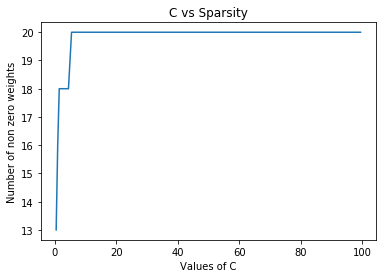

In [85]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

> A weird plot number of non-zero weights are constant for every value of c above 7

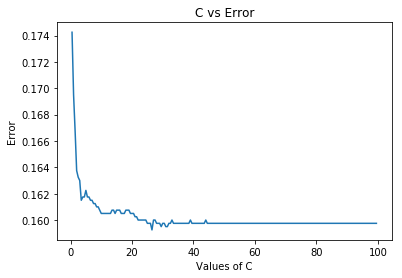

In [86]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()

#### Feature importance :
1. Testing multicollinearity.
2. Getting important features.

** Pertubation test **

In [87]:
# Adding small noise to train data.
epsilon = 0.05
sent_train_2 = pd.DataFrame(sent_vectors_train) + epsilon
sent_train_2.shape

(6000, 20)

In [88]:
# training Logistic Regression on this new modified dataset.
m1 = LogisticRegression()
m1.fit(sent_train_2, y_train)
m1.coef_

array([[-0.43741291,  2.74427164, -6.05536018, -0.09377851,  0.21450053,
        -0.43256888,  0.76795172, -4.54993666, -5.9223589 , -2.07740081,
         0.60960077,  1.38418837,  0.05266378, -2.44586776,  4.11047967,
        -4.48285594,  3.99680516,  0.43301614, -2.67120429,  3.60955545]])

In [89]:
# Trainiong Logistic Regression on old dataset.
m2 = LogisticRegression()
m2.fit(sent_vectors_train, y_train)
m2.coef_

array([[-0.38865881,  2.7828024 , -6.01414192, -0.1397038 ,  0.22929874,
        -0.41575759,  0.8319719 , -4.51184383, -5.87093576, -2.08699565,
         0.66241686,  1.41005452,  0.03815616, -2.37585819,  4.09757757,
        -4.44734572,  4.05116054,  0.46075331, -2.62830915,  3.65069207]])

In [90]:
m2.coef_ - m1.coef_

array([[ 0.0487541 ,  0.03853076,  0.04121825, -0.04592529,  0.01479821,
         0.01681129,  0.06402018,  0.03809284,  0.05142314, -0.00959484,
         0.05281609,  0.02586615, -0.01450762,  0.07000957, -0.0129021 ,
         0.03551022,  0.05435538,  0.02773717,  0.04289514,  0.04113663]])

> As we can see that the difference between two models w and w~ is small we can say that the features are not multicollinear.
> As a result we can use w to get the feature importance.

** Getting most important features ** 

In [91]:
w_star = np.absolute(m2.coef_)
w_star.sort()
w_star

array([[ 0.03815616,  0.1397038 ,  0.22929874,  0.38865881,  0.41575759,
         0.46075331,  0.66241686,  0.8319719 ,  1.41005452,  2.08699565,
         2.37585819,  2.62830915,  2.7828024 ,  3.65069207,  4.05116054,
         4.09757757,  4.44734572,  4.51184383,  5.87093576,  6.01414192]])

### TFIDF W2V:

In [92]:
# We will first create tfidf w2v features.
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [93]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))
print (tfidf_sent_vectors_train[0])

6000
20
[ 0.22006736 -0.54588591 -0.52012178  0.8531952  -0.32471348  0.83727
 -0.38081365  0.6977497  -0.09870965  0.2485846  -0.22098471 -0.05520562
 -0.40372835 -0.14965521  0.79679537 -0.09392595  0.45991806 -0.01518098
 -0.23502534 -0.10381713]


In [94]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))
print (tfidf_sent_vectors_test[0])

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning:

invalid value encountered in true_divide



4000
20
[ 0.34880667 -0.66722768 -0.69154086  1.296361   -0.49369094  1.16639824
 -0.40225478  0.92290689 -0.03250262  0.35982068 -0.44986888 -0.22254947
 -0.46654497 -0.21033446  1.08664227 -0.09513174  0.51212694 -0.00651806
 -0.16105411 -0.17828285]


In [95]:
# Using grid search to find optimal C or 1/lamda
model1 = GridSearchCV(lr1, C)
model1.fit(tfidf_sent_vectors_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
# Getting the best model
model1.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
# nan values are assigned 0 (if present)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)

In [98]:
# Evaluating the model
model1.score(tfidf_sent_vectors_test, y_test)

0.54949999999999999

In [99]:
# Performing gridsearch this time with l2 regularisation.
model2 = GridSearchCV(lr2, C)
model2.fit(tfidf_sent_vectors_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
model2.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [101]:
model2.score(tfidf_sent_vectors_test, y_test)

0.54974999999999996

** Grid Search Result **
* GridSearch gave the value of C as 100 for l1 and C = 1000 for l2 regularized model.
* Accuracy obtained for TFIDF W2V is horrible its almost as good as random guessing.

** Using RandomizedSearchCV now **

In [102]:
# Using RandomizedSearchCv
model3 = RandomizedSearchCV(lr1, C_rscv)
model3.fit(tfidf_sent_vectors_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [103]:
# Getting the best estimator
model3.best_estimator_

LogisticRegression(C=90, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [104]:
# Score obtained.
model3.score(tfidf_sent_vectors_test, y_test)

0.54974999999999996

In [105]:
# Doing the same thing for model lr2.
model4 = RandomizedSearchCV(lr2, C_rscv)
model4.fit(tfidf_sent_vectors_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286D0E06860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [106]:
model4.best_estimator_

LogisticRegression(C=90, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
model4.score(tfidf_sent_vectors_test, y_test)

0.55100000000000005

** RandomSearch Cv result **
* Randomized search gave the value of C = 90 for l1 regularized model and C = 90 for l2 regularized model.
* Accuracy is still low.

** Now checking sparsity with different values of lamda or C **

In [108]:
C_sparse = np.arange(0, 100, 0.5)
C_sparse = C_sparse[1:]
C_sparse.shape

(199,)

In [109]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(tfidf_sent_vectors_train, y_train)
    error.append(1- m.score(tfidf_sent_vectors_test, y_test))
    spc.append(np.count_nonzero(m.coef_))

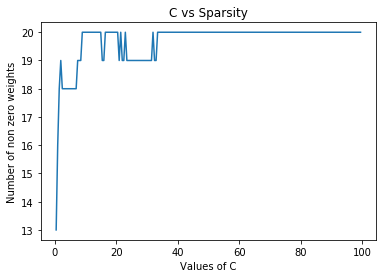

In [110]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.plot(C_sparse, spc)
plt.show()

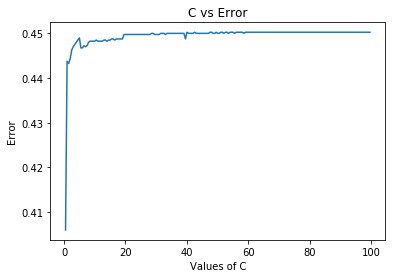

In [111]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(C_sparse, error)
plt.show()

#### Feature importance :
1. Testing multicollinearity.
2. Getting important features.

** Pertubation test **

In [112]:
# Adding small noise to train data.
epsilon = 0.05
sent_train_2 = pd.DataFrame(tfidf_sent_vectors_train) + epsilon
sent_train_2.shape

(6000, 20)

In [113]:
# training Logistic Regression on this new modified dataset.
m1 = LogisticRegression()
m1.fit(sent_train_2, y_train)
m1.coef_

array([[-0.22496666,  3.06806684, -4.44645295, -0.38881778,  0.13987302,
        -0.67241548,  0.49649017, -3.88160618, -5.85991262, -1.49014833,
         0.77564297,  0.69891399,  0.08679583, -2.23379094,  3.45546292,
        -4.01986676,  3.8758762 ,  0.20652695, -2.35020734,  3.35771009]])

In [114]:
# Trainiong Logistic Regression on old dataset.
m2 = LogisticRegression()
m2.fit(tfidf_sent_vectors_train, y_train)
m2.coef_

array([[-0.22596075,  3.07405163, -4.44703683, -0.39915368,  0.12970545,
        -0.68419178,  0.49066444, -3.89849341, -5.86466737, -1.49085284,
         0.77543453,  0.70151485,  0.09338781, -2.2439673 ,  3.45122013,
        -4.02898543,  3.86271294,  0.19726465, -2.35602524,  3.34937508]])

In [115]:
m2.coef_ - m1.coef_

array([[-0.00099409,  0.00598479, -0.00058387, -0.0103359 , -0.01016757,
        -0.0117763 , -0.00582573, -0.01688723, -0.00475475, -0.00070451,
        -0.00020844,  0.00260086,  0.00659198, -0.01017636, -0.00424279,
        -0.00911867, -0.01316326, -0.0092623 , -0.0058179 , -0.00833501]])

> As we can see that the difference between two models w and w~ is small we can say that the features are not multicollinear.
> As a result we can use w to get the feature importance.

** Getting most important features ** 

In [116]:
w_star = np.absolute(m2.coef_)
w_star.sort()
w_star

array([[ 0.09338781,  0.12970545,  0.19726465,  0.22596075,  0.39915368,
         0.49066444,  0.68419178,  0.70151485,  0.77543453,  1.49085284,
         2.2439673 ,  2.35602524,  3.07405163,  3.34937508,  3.45122013,
         3.86271294,  3.89849341,  4.02898543,  4.44703683,  5.86466737]])

## Conclusions :
** Bag of Words **
1. The bag of words model has overall higher accuracy than all other models trained.
2. The C vs Error plot here does not make sense at - all, as C increases lamda decreases and when that happens sparsity decreases that is error should decrease but the plot says something else, reason - unknown.

** TFIDF **
1. TFIDF also gives almost the same accuracy as BOW.
2. The C vs Error plot here is weird too, first the error drops to some minimum point then increase and stabilizes.

** AVG W2V **
1. The average W2V has a lesser overall accuracy than both TFIDF and BagofWords.
2. The C vs Error plot here makes sense as C increases error decreases.

** TFIDF W2V **
1. The accuracy for this is the worst it's almost similar to random guessing.

<table>
    <tr>
    <th>Model</th><th>GridSearchCV paramter C Value</th><th>RandomizedSearchCV parameter C Value</th>
    </tr>
    <tr>
    <td>BOW L1</td><td>1</td><td>57</td>
    </tr>
    <tr>
    <td>BOW L2</td><td>1</td><td>5</td>
    </tr>
    <tr>
    <td>TFIDF L1</td><td>10</td><td>29</td>
    </tr>
    <tr>
    <td>TFIDF L2</td><td>10</td><td>15</td>
    </tr>
    <tr>
    <td>AVG W2V L1</td><td>100</td><td>81</td>
    </tr>
    <tr>
    <td>AVG W2V L2</td><td>10000</td><td>45</td>
    </tr>
    <tr>
    <td>TFIDF W2V L1</td><td>100</td><td>90</td>
    </tr>
    <tr>
    <td>TFIDF W2V L2</td><td>1000</td><td>90</td>
    </tr>
</table>